# Image calibration

When capturing images of the night sky, amateur and professional astronomers alike must contend with various sources of noise and distortion that affect their raw data. The process of removing these imperfections is called image calibration, and it's a critical first step in producing scientifically valuable astronomical images. 

In this tutorial we go through the calibration of a science image from the [photometry dataset](datasets).

Three primary calibration frames are used in this process:

- **Bias Frames** capture the electronic noise inherent in the camera's sensor even without exposure to light. This *read noise* appears as a baseline signal that varies slightly across the detector. Bias frames are taken with the shortest possible exposure time and with the camera shutter closed.

- **Dark Frames** account for thermal noise or *dark current* that builds up during exposure. As the camera sensor operates, heat generates electrons that register as false signal. Dark frames are captured with the same exposure duration as the science images but with the shutter closed, allowing astronomers to subtract this thermal signature.

- **Flat Frames** correct for uneven illumination across the field of view caused by dust, vignetting, and optical imperfections. These are created by imaging an evenly illuminated surface (like the dawn sky or a light box) with the same optical configuration used for science images.

By mathematically combining these calibration frames with raw science images, astronomers can dramatically improve image quality, revealing faint details and ensuring accurate photometric measurements that would otherwise be obscured by instrumental artifacts.

## Files selection

We first list all the FITS files in the repository and retrieve their headers. Form these headers, we get the images dates and type of exposure (bias, dark, flat or light).

```{note}
In our case, the information about the type of image is stored in the filename but it is common to find it in the image header, for example under the `IMAGETYP` keyword.
```

In [1]:
from astropy.io import fits
from dateutil import parser
from glob import glob
from collections import defaultdict
from pathlib import Path
from datetime import timedelta

files = glob("./photometry_raw_data/**/*.fit*")
files_meta = defaultdict(dict)
observations = defaultdict(lambda: defaultdict(int))

for file in files:
    header = fits.getheader(file)
    file_date = parser.parse(header["DATE-OBS"])
    # because some observation are taken over midgnight
    file_date = file_date - timedelta(hours=10)
    files_meta[file]["date"] = file_date
    files_meta[file]["type"] = Path(file).parent.stem
    observations[file_date.date()][files_meta[file]["type"]] += 1

Notice how we also created an `observations` dictionary to store the number of files per date and type. Let's print its content

In [2]:
for date, obs in observations.items():
    print(date, f"\n{'-' * len(str(date))}")
    for obs_type, count in obs.items():
        print(f"{obs_type}: {count}")

2016-01-05 
----------
ScienceImages: 336
Bias: 16
Flats: 16
Darks: 16


We then select the science image we want to calibrate, simply the first one in our set

In [3]:
# only picking up the science images
lights = list(filter(lambda f: files_meta[f]["type"] == "ScienceImages", files))
# sorting them by date
lights = sorted(lights, key=lambda f: files_meta[f]["date"])
# seleting the first one
file = lights[0]

observation_date = files_meta[list(lights)[0]]["date"].date()

## Master calibration images

A master calibration image is a high-quality, refined calibration frame created by combining multiple individual calibration frames of the same type. Rather than applying individual bias, dark, or flat frames directly to your science image, we will create master calibration frames first to improve signal-to-noise ratio and reduce random errors.

In the following cell, we then select the calibration files that match our main observation's date.

In [4]:
def filter_files(files, file_type):
    return list(
        filter(
            lambda f: files_meta[f]["type"] == file_type
            and files_meta[f]["date"].date() == observation_date,
            files,
        )
    )


biases = filter_files(files, "Bias")
darks = filter_files(files, "Darks")
flats = filter_files(files, "Flats")

```{note}
This step is not necessary in our case since all calibration images were taken the day of the observation, but it comes handy when we have more than one night of images
```

From these files, we then create a master bias, dark and flat that will be used to calibrate our light frames.

In [5]:
from eloy import calibration

bias = calibration.master_bias(files=biases)
dark = calibration.master_dark(files=darks, bias=bias)
flat = calibration.master_flat(files=flats, bias=bias, dark=dark)

Let's plot them together with our science image

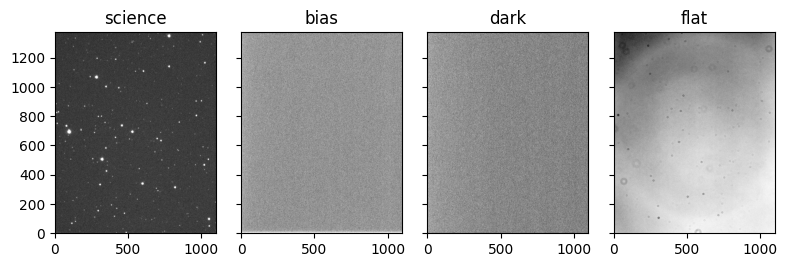

In [6]:
import matplotlib.pyplot as plt
from eloy import viz

fig, axes = plt.subplots(sharex=True, sharey=True, nrows=1, ncols=4, figsize=(8, 3))
axes[0].imshow(viz.z_scale(fits.getdata(file)).T, cmap="Greys_r", origin="lower")
axes[0].set_title("science")
axes[1].imshow(viz.z_scale(bias).T, cmap="Greys_r", origin="lower")
axes[1].set_title("bias")
axes[2].imshow(viz.z_scale(dark).T, cmap="Greys_r", origin="lower")
axes[2].set_title("dark")
axes[3].imshow(viz.z_scale(flat).T, cmap="Greys_r", origin="lower")
axes[3].set_title("flat")
plt.tight_layout()

## Calibration

We can now calibrate our science image

In [7]:
data = fits.getdata(file)
header = fits.getheader(file)
exposure = header["EXPTIME"]

# calibration
calibrated_data = calibration.calibrate(data, exposure, dark, flat, bias)

As you can see we used the exposure time of the image, required to properly scale the flat correction. Let's plot the calibrated image next to its raw version 

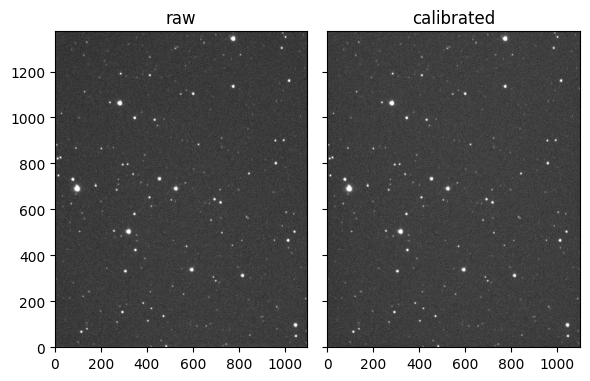

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharex=True, sharey=True)
axes[0].imshow(viz.z_scale(fits.getdata(file)).T, cmap="Greys_r", origin="lower")
axes[0].set_title("raw")
axes[1].imshow(viz.z_scale(calibrated_data).T, cmap="Greys_r", origin="lower")
axes[1].set_title("calibrated")
plt.tight_layout()

From here, we can perform measurements on our calibrated science image, cleaned from bias, flat and dark signals.

## Saving calibrated images

In order to use them in the next tutorials, we will calibrate and save all the raw images from the  [photometry dataset](datasets).

In [9]:
from tqdm.auto import tqdm

calibrated_folder = Path("calibrated_images")
calibrated_folder.mkdir(exist_ok=True)

for file in tqdm(lights):
    data = fits.getdata(file)
    header = fits.getheader(file)
    exposure = header["EXPTIME"]

    # calibration
    calibrated_data = calibration.calibrate(data, exposure, dark, flat, bias)
    hdu = fits.PrimaryHDU(data=calibrated_data, header=header)
    filename = calibrated_folder / f"{Path(file).stem}.fits"
    hdu.writeto(filename)

  0%|          | 0/336 [00:00<?, ?it/s]